Загрузка необходимых библиотек

In [1]:
import os
import cv2
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import zipfile

from PIL import Image
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from keras import backend as K

from tensorflow import keras
from tensorflow.keras.utils import plot_model
from tensorflow.math import log , reduce_mean
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.layers import *
from keras.models import Model
from keras import backend as K
from keras.models import Model
from tensorflow.keras import layers
from keras.layers import Input, Conv2D, DepthwiseConv1D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda, Activation, Add
from IPython.display import Audio
from keras.layers import *
from keras.models import Model
import random
import gc
from keras.optimizers import Adam
from keras.losses import binary_crossentropy
from keras.metrics import binary_accuracy
from sklearn.model_selection import train_test_split
import numpy as np
from keras import backend as K
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.callbacks import Callback
from keras.utils import generic_utils
from patchify import patchify

Распаковка архива

In [2]:
current_dir = os.getcwd()
print(current_dir)
root_directory = current_dir + '/DATA/CamVid'
print(root_directory)
scaler = MinMaxScaler()

/Users/kopytko/Yandex.Disk.localized/МТУСИ/ВКР/SegPTA
/Users/kopytko/Yandex.Disk.localized/МТУСИ/ВКР/SegPTA/DATA/CamVid


Сохранение снимков в датасет

In [3]:
image_dataset = []

for path, subdirs, files in os.walk(root_directory):
    dirname = path.split(os.path.sep)[-1]
    if dirname == 'train':
        images = os.listdir(path)
        images.sort()
        for i, image_name in enumerate(images):
            if image_name.endswith(".png"):
                image = cv2.imread(path + "/" + image_name, 1)
                image = cv2.resize(image, (960, 720))  
                image = scaler.fit_transform(image.reshape(-1, image.shape[-1])).reshape(image.shape)
                image_dataset.append(image)

image_dataset_val = []

Сохранение меток в датасет

In [4]:
mask_dataset = []

for path, subdirs, files in os.walk(root_directory):
    dirname = path.split(os.path.sep)[-1]
    if dirname == 'train_labels':
        masks = os.listdir(path)
        masks.sort()
        for i, mask_name in enumerate(masks):
            if mask_name.endswith(".png"):
                mask = cv2.imread(path + '/' + mask_name, 1)
                mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
                mask = cv2.resize(mask, (960, 720))  
                mask_dataset.append(mask)

libpng warning: iCCP: known incorrect sRGB profile


Ограничивание размера датасета

In [5]:
image_dataset = np.array(image_dataset)
mask_dataset =  np.array(mask_dataset)

print(f"Размерность датасета изображений: {image_dataset.shape}")
print(f"Размерность датасета меток: {mask_dataset.shape}")

Размерность датасета изображений: (701, 720, 960, 3)
Размерность датасета меток: (701, 720, 960, 3)


Проверка соотвествие снимков и масок

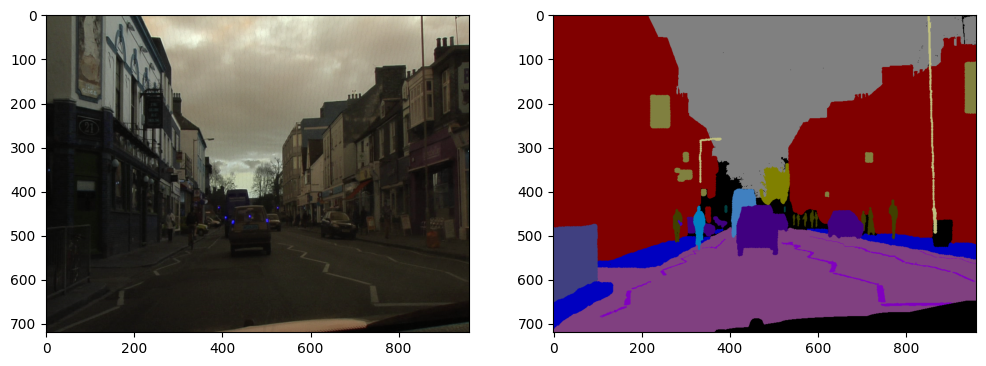

In [11]:
image_number = random.randint(0, len(image_dataset))

plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(image_dataset[image_number])
plt.subplot(122)
plt.imshow(mask_dataset[image_number])
plt.show()

Инициализация меток

In [12]:
Animal = np.array([64, 128, 64])
Archway = np.array([192, 0, 128])
Bicyclist = np.array([0, 128, 192])
Bridge = np.array([0, 128, 64])
Building = np.array([128, 0, 0])
Car = np.array([64, 0, 128])
CartLuggagePram = np.array([64, 0, 192])
Child = np.array([192, 128, 64])
Column_Pole = np.array([192, 192, 128])
Fence = np.array([64, 64, 128])
LaneMkgsDriv = np.array([128, 0, 192])
LaneMkgsNonDriv = np.array([192, 0, 64])
Misc_Text = np.array([128, 128, 64])
MotorcycleScooter = np.array([192, 0, 192])
OtherMoving = np.array([128, 64, 64])
ParkingBlock = np.array([64, 192, 128])
Pedestrian = np.array([64, 64, 0])
Road = np.array([128, 64, 128])
RoadShoulder = np.array([128, 128, 192])
Sidewalk = np.array([0, 0, 192])
SignSymbol = np.array([192, 128, 128])
Sky = np.array([128, 128, 128])
SUVPickupTruck = np.array([64, 128, 192])
TrafficCone = np.array([0, 0, 64])
TrafficLight = np.array([0, 64, 64])
Train = np.array([192, 64, 128])
Tree = np.array([128, 128, 0])
Truck_Bus = np.array([192, 128, 192])
Tunnel = np.array([64, 0, 64])
VegetationMisc = np.array([192, 192, 0])
Void = np.array([0, 0, 0])
Wall = np.array([64, 192, 0])

Преобразование меток из цветного изображения в двумерный массив масок 

In [13]:
label = mask

def rgb_to_2D_label(label):
    label_seg = np.zeros(label.shape, dtype=np.uint8)

    label_seg[np.all(np.equal(label, Sky), axis=-1)] = 1
    
    label_seg = label_seg[:,:,0]
    
    return label_seg

labels = []
for i in range(mask_dataset.shape[0]):
    label = rgb_to_2D_label(mask_dataset[i])
    labels.append(label)
    
labels = np.array(labels)

Преобразованик в двоичную матрицу класса (добавляется ось)

In [14]:
labels_cat = to_categorical(labels)
n_classes = len(np.unique(labels))
print(n_classes)

2


Проверка изображения и метки

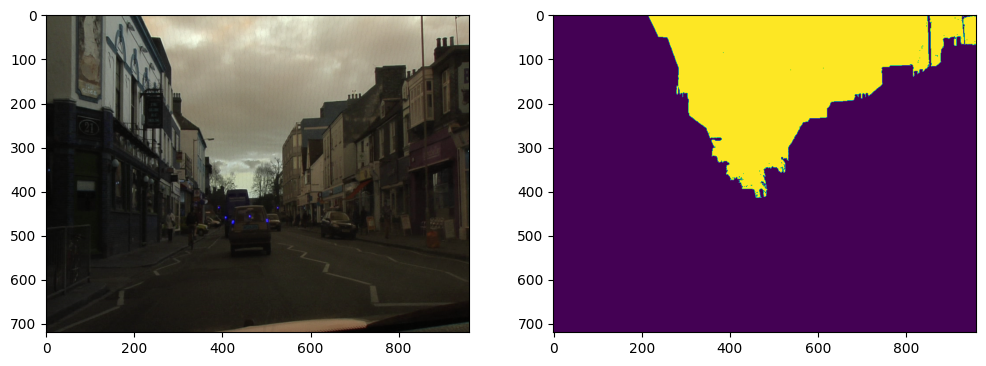

In [19]:
image_number = random.randint(0, len(image_dataset))

plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(image_dataset[image_number])
plt.subplot(122)
plt.imshow(labels[image_number], vmin=0, vmax=1)
plt.show()

Разбитие данных на тренировочную и проверочную выборки

In [20]:
del mask_dataset, labels

X_train, X_test, y_train, y_test = train_test_split(image_dataset, labels_cat, test_size=0.3, random_state=442)

del image_dataset, labels_cat

Модель (архитектура)

In [21]:
gc.collect()

#Функция, которая описывает блок inverted residual block
def mobilenet_block(inputs, expansion_ratio, stride, kernel, filters, activation, squeeze_and_excitation, name = None):
    in_channels = inputs.shape[-1]
    pointwise_filters = int(expansion_ratio * in_channels)
    
    # Expand
    x = Conv2D(pointwise_filters, kernel_size=(1, 1), 
               padding='same',name=name+'_expand')(inputs)
    x = BatchNormalization(name=name+'_expand_bn')(x)
    if activation == 'relu':
        x = ReLU(6.0, name=name+'_expand_relu1')(x)
    elif activation == 'hard_swish':
        x = Activation(hard_swish, name=name+'_expand_hard_swish1')(x)
    
    # Depthwise
    x = DepthwiseConv2D(kernel_size=kernel, strides=stride, 
                        padding='same', name=name+'_depthwise')(x)
    x = BatchNormalization(name=name+'_depthwise_bn')(x)
    if activation == 'relu':
        x = ReLU(6.0, name=name+'_expand_relu2')(x)
    elif activation == 'hard_swish':
        x = Activation(hard_swish, name=name+'_expand_hard_swish2')(x)
    
    # Squeeze and Excitation
    if squeeze_and_excitation == True:
        se_channels = max(1, int(in_channels * 0.25))
        se = GlobalAveragePooling2D(name=name+'_global_average_pool')(x)
        se = Dense(se_channels, activation='relu', name=name+'_dense1')(se)
        se = Dense(pointwise_filters, activation='hard_sigmoid', name=name+'_dense2')(se)
        x = Multiply(name=name+'_multiply')([x, se])
    
    # Project
    x = Conv2D(filters, kernel_size=(1, 1), padding='same', 
               name=name+'_project')(x)
    x = BatchNormalization(name=name+'_project_bn')(x)
    
    # Skip connection
    if in_channels == filters and stride == 1:
        x = Add(name=name+'_add')([x, inputs])
    return x

#Реализация PTA блока (из двух последовательных и одного параллельного inverted_residual_block)
def pta_block(inputs, expansion_ratio, stride, filters, name = None, study = True, adaptive_selector=1):
    if study == True:
        # Параллельный inverted residual block
        x = mobilenet_block(inputs, expansion_ratio, stride, (5, 5), filters, activation='hard_swish', 
                               squeeze_and_excitation = True, name=name+'_inv_residual_block1')
        # Первый последовательный inverted residual block
        y = mobilenet_block(inputs, expansion_ratio, stride, (5, 5), filters, activation='hard_swish', 
                               squeeze_and_excitation = True, name=name+'_inv_residual_block2')
        # Второй последовательный inverted residual block
        y = mobilenet_block(y, expansion_ratio, stride, (5, 5), filters, activation='hard_swish', 
                               squeeze_and_excitation = True, name=name+'_inv_residual_block3') 

        z = tf.keras.layers.Average(name=name + '_average')([x, y])

    if study == False:
        if adaptive_selector == 0:
            print("Выбрана легкая ветвь")
            z = mobilenet_block(inputs, expansion_ratio, 1, (5, 5), filters, activation='hard_swish', 
                               squeeze_and_excitation = True, name=name+'_inv_residual_block1') 
        if adaptive_selector == 1:
            print("Выбрана тяжелая ветвь")
            z = mobilenet_block(inputs, expansion_ratio, 1, (5, 5), filters, activation='hard_swish', 
                               squeeze_and_excitation = True,name=name+'_inv_residual_block2')
            z = mobilenet_block(z, expansion_ratio, 1, (5, 5), filters, activation='hard_swish', 
                               squeeze_and_excitation = True, name=name+'_inv_residual_block3')
        z = tf.keras.layers.Average(name=name + '_average')([z, z])
    return z    

def hard_swish(x):
    return x * tf.nn.relu6(x + 3) / 6.0

#Функция двойной светки 
def double_conv_block(x, n_filters, name = None):
    #Применяем сверточный слой Conv2D вместе с ReLU активацией
    x = Conv2D(n_filters, 3, activation=hard_swish, kernel_initializer='he_normal', 
             padding='same', name=name+'d_conv1')(x)
    #Применяем сверточный слой Conv2D вместе с ReLU активацией
    x = Conv2D(n_filters, 3, activation=hard_swish, kernel_initializer='he_normal', 
             padding='same', name=name+'d_conv2')(x)
    return x

#Функция проверки входит ли число в заданный диапазон
def int_within_bounds(n, lower, upper):
    return n in range(lower, upper)

#Функция описания модели
def unet_model(n_classes, input_shape = (720,960,3), alpha = 1.0, study = True, a1 = 1, a2 = 1, a3 = 1, activ = 'softmax'):
    if study == True:
        print("Включен режим обучения")
    else:
        print("Отключен режим обучения")
     

    img_input = Input(input_shape,name="input_image")

    filters=[16,32,64,128,256]
    # Кодеровщик:
    c1 = double_conv_block(img_input,filters[0], name="encoder_block11")
    p1 = MaxPooling2D(pool_size=(2, 2),name= "pool1")(c1)  
    c2 = mobilenet_block(p1, 2, 1, (3, 3), filters[1], activation='relu', squeeze_and_excitation = False, name="encoder_block21")
    c2 = mobilenet_block(c2, 2, 1, (3, 3), filters[1], activation='relu', squeeze_and_excitation = False, name="encoder_block22")
    p2 = MaxPooling2D(pool_size=(2, 2),name= "pool2")(c2) 
    c3 = mobilenet_block(p2, 2, 1, (3, 3), filters[2], activation='relu', squeeze_and_excitation = False, name="encoder_block31")
    c3 = mobilenet_block(c3, 2, 1, (3, 3), filters[2], activation='relu', squeeze_and_excitation = False, name="encoder_block32")
    c3 = mobilenet_block(c3, 2, 1, (3, 3), filters[2], activation='relu', squeeze_and_excitation = False, name="encoder_block33")
    p3 = MaxPooling2D(pool_size=(2, 2),name= "pool3")(c3) 
    c4 = mobilenet_block(p3, 2, 1, (5, 5), filters[3], activation='hard_swish', squeeze_and_excitation = True, name="encoder_block41")
    c4 = mobilenet_block(c4, 2, 1, (5, 5), filters[3], activation='hard_swish', squeeze_and_excitation = True, name="encoder_block42")
    c4 = pta_block(c4, 2, 1, filters[3],adaptive_selector = a1, study=study, name="encoder_block43")
    c4 = mobilenet_block(c4, 2, 1, (5, 5), filters[3], activation='hard_swish', squeeze_and_excitation = True, name="encoder_block44")
    c4 = pta_block(c4, 2, 1, filters[3],adaptive_selector = a2, study=study, name="encoder_block45")
    p4 = MaxPooling2D(pool_size=(2, 2),name= "pool4")(c4) 
    c5 = mobilenet_block(p4, 2, 1, (5, 5), filters[4], activation='hard_swish', squeeze_and_excitation = True, name="encoder_block51")    
    c5 = pta_block(c5, 2, 1, filters[4], adaptive_selector = a3, study=study, name="encoder_block52")
    c5 = mobilenet_block(c5, 2, 1, (5, 5), filters[4], activation='hard_swish', squeeze_and_excitation = True, name="encoder_block53")
    c5 = double_conv_block(c5,filters[4], name="encoder_block54")
    
    # Декодедеровщик:
    u6 = double_conv_block(UpSampling2D(size=(2, 2))(c5),filters[3], name="decoder_block1")
    u6 = Concatenate()([u6, c4])
    u7 = double_conv_block(UpSampling2D(size=(2, 2))(u6),filters[2], name="decoder_block2")
    u7 = Concatenate()([u7, c3])
    u8 = double_conv_block(UpSampling2D(size=(2, 2))(u7),filters[1], name="decoder_block3")
    u8 = Concatenate()([u8, c2])
    c9 = double_conv_block(UpSampling2D(size=(2, 2))(u8),filters[0], name="decoder_block4")

    # Output
    outputs = Conv2D(n_classes, kernel_size=(1, 1), activation='sigmoid', name='finish')(c9)
    model = Model(inputs=img_input, outputs=outputs)
    return model


In [22]:
model = unet_model(n_classes,(720, 960, 3))

Включен режим обучения
Metal device set to: Apple M1


In [23]:
gc.collect()

def list_from_select_layers (model, word_for_find):
    list1 =[]
    for layer in model.layers:
        if word_for_find in layer.name:
            #print(layer.name)
            list1.append(layer)
    return list1


class TrainableCallback(Callback):
    def __init__(self, layers1,layers2,layers3,layers4,layers5,layers6, epochs_to_train):
        super(TrainableCallback, self).__init__()
        self.layers1 = layers1
        self.layers2 = layers2 
        self.layers3 = layers3
        self.layers4 = layers4 
        self.layers5 = layers5
        self.layers6 = layers6  
        self.epochs_to_train = epochs_to_train

    def on_epoch_begin(self, epoch, logs=None):
        PTA_VAR = random.randint(1,100)
        a1 = a2 = a3 = 1  
        #определяем случайным образом конфигурацию 
        if int_within_bounds(PTA_VAR,35,50) == True:
            a1 = a2 = 0
            print("Light,Light,Heavy")
        elif int_within_bounds(PTA_VAR,50,70) == True: 
            a2 = 0
            print("Heavy,Ligth,Heavy")
        elif int_within_bounds(PTA_VAR,70,90) == True:      
            a3 = 0
            print("Heavy,Heavy,Ligth")
        elif int_within_bounds(PTA_VAR,90,100) == True:
            a1 = a2 = a3 = 0
            print("Ligth,Ligth,Ligth")
        else:
            print("Heavy,Heavy,Heavy") 

        if a1 == 1:
            for layer in self.layers1:
                layer.trainable = True
            for layer in self.layers2:
                layer.trainable = False                
        else:
            for layer in self.layers1:
                layer.trainable = False
            for layer in self.layers2:
                layer.trainable = True 

        if a2 == 1:
            for layer in self.layers3:
                layer.trainable = True
            for layer in self.layers4:
                layer.trainable = False                
        else:
            for layer in self.layers3:
                layer.trainable = False
            for layer in self.layers4:
                layer.trainable = True 


        if a3 == 1:
            for layer in self.layers5:
                layer.trainable = True
            for layer in self.layers6:
                layer.trainable = False                
        else:
            for layer in self.layers5:
                layer.trainable = False
            for layer in self.layers6:
                layer.trainable = True 

list1 = list_from_select_layers(model, 'block43_inv_residual_block3')
list3 = list_from_select_layers(model, 'block45_inv_residual_block3')
list5 = list_from_select_layers(model, 'block51_inv_residual_block3')
list2 = list_from_select_layers(model, 'block43_inv_residual_block2') + list_from_select_layers(model, 'block43_inv_residual_block1')
list4 = list_from_select_layers(model, 'block45_inv_residual_block2') + list_from_select_layers(model, 'block45_inv_residual_block1')
list6 = list_from_select_layers(model, 'block52_inv_residual_block2') + list_from_select_layers(model, 'block52_inv_residual_block1')

Создание коллбэков и компиляция модели

In [24]:
# Создание обратного вызова
trainable_callback = TrainableCallback(list1, list2, list3, list4, list5, list6, epochs_to_train=1)

# Компиляция модели и обучение с использованием обратного вызова
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics='accuracy')   

Обучение модели

In [ ]:
gc.collect()
model.fit(X_train, y_train, batch_size=4, epochs=100, callbacks=[trainable_callback])   

In [ ]:
weights_path = 'MobileUNet-PTA(Sky).h5'
print(f"Сохранение весов в по пути: {weights_path}")
model.save_weights('MobileUNet-PTA(Sky).h5')
print(f"Сохранение весов произведено успешно")
sound_file = 'http://codeskulptor-demos.commondatastorage.googleapis.com/GalaxyInvaders/bonus.wav'
Audio(sound_file, autoplay=True)

Загрузка весов

In [25]:
model.load_weights('MobileUNet-PTA(Sky).h5')
print("Веса загружены")

Веса загружены


Вывод результатов работы модели в виде предсказанных значений

In [58]:
#Выводим предсказанные значения
def predict(train_model):
    vmin = 0
    vmax = 1

    for i in range(1):
      
        image_number = random.randint(0, X_test.shape[0])
      
        plt.figure(figsize=(24, 6))
      
        plt.subplot(141)
        plt.title('Image')
        plt.imshow(X_test[image_number])
      
        plt.subplot(142)
        plt.title('True')
        true = y_test[image_number].argmax(axis=2)
        plt.imshow(true, vmin = vmin, vmax = vmax)
      
        plt.subplot(143)
        plt.title('Prediction')
        image_1 = Image.open('2.png')
        image_1.thumbnail((920, 720))
        plt.imshow(image_1)
      
        plt.show()  

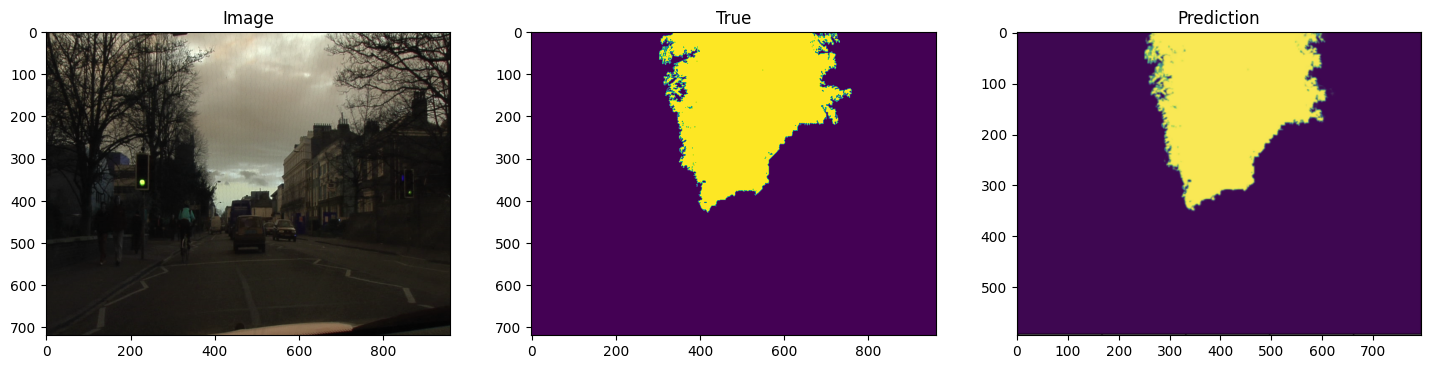

In [54]:
predict(model)

In [55]:
def copy_weights1(source_model, target_model, ignore_layers=[]):
    # Получаем веса из исходной модели
    source_weights = source_model.get_weights()

    # Устанавливаем веса в целевую модель
    for i, layer in enumerate(target_model.layers):
        # Игнорируем слои из списка и слои нулевой длины
        if any(ignore_layer in layer.name for ignore_layer in ignore_layers) or len(layer.get_weights()) == 0:
            continue

        # Получаем веса из исходной модели для данного слоя
        source_layer = source_model.get_layer(name=layer.name)
        source_weights_layer = source_layer.get_weights()

        # Устанавливаем веса в целевую модель для данного слоя
        layer.set_weights(source_weights_layer)    

In [56]:
list1 = ['encoder_block45_inv_residual_block2','encoder_block45_inv_residual_block3',
         'encoder_block43_inv_residual_block2','encoder_block45_inv_residual_block3',
         'encoder_block45_inv_residual_block2','encoder_block45_inv_residual_block3'
         ]
model_lll = unet_model(n_classes,(720, 960, 3),study=False,a1=0,a2=0,a3=0)
model_lll.compile(optimizer='adam', loss='categorical_crossentropy', metrics='accuracy')

# Копирование весов из исходной модели в копию с удаленными слоями
copy_weights1(model,model_lll,list1)

Отключен режим обучения
Выбрана легкая ветвь
Выбрана легкая ветвь
Выбрана легкая ветвь


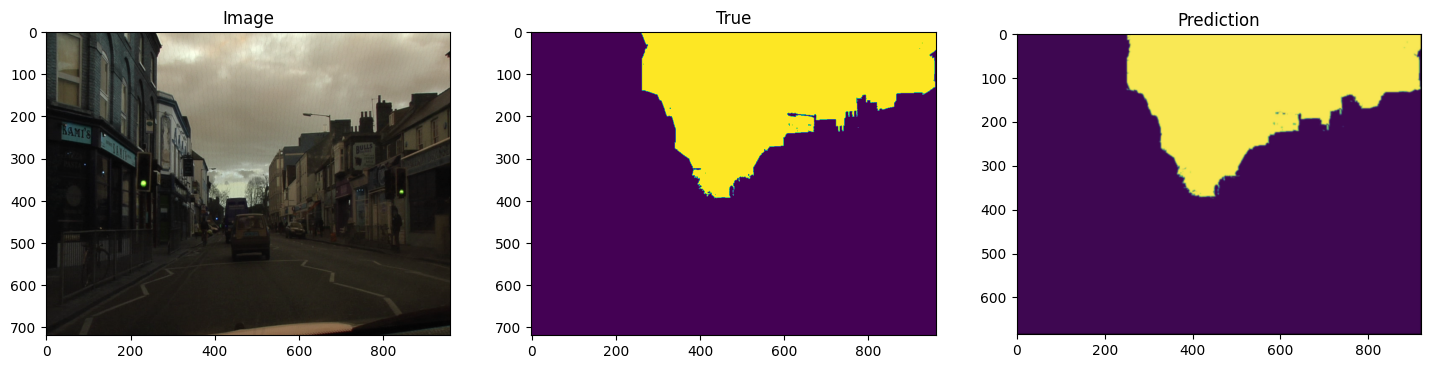

In [91]:
predict(model_lll)

In [94]:
list2 = ['encoder_block45_inv_residual_block1',
         'encoder_block45_inv_residual_block2','encoder_block45_inv_residual_block3',
         'encoder_block45_inv_residual_block2','encoder_block45_inv_residual_block3'
         ]
model_llh = unet_model(n_classes,(720, 960, 3),study=False,a1=1,a2=0,a3=0)
model_llh.compile(optimizer='adam', loss='categorical_crossentropy', metrics='accuracy')

# Копирование весов из исходной модели в копию с удаленными слоями
copy_weights1(model,model_llh,list2)

Отключен режим обучения
Выбрана тяжелая ветвь
Выбрана легкая ветвь
Выбрана легкая ветвь


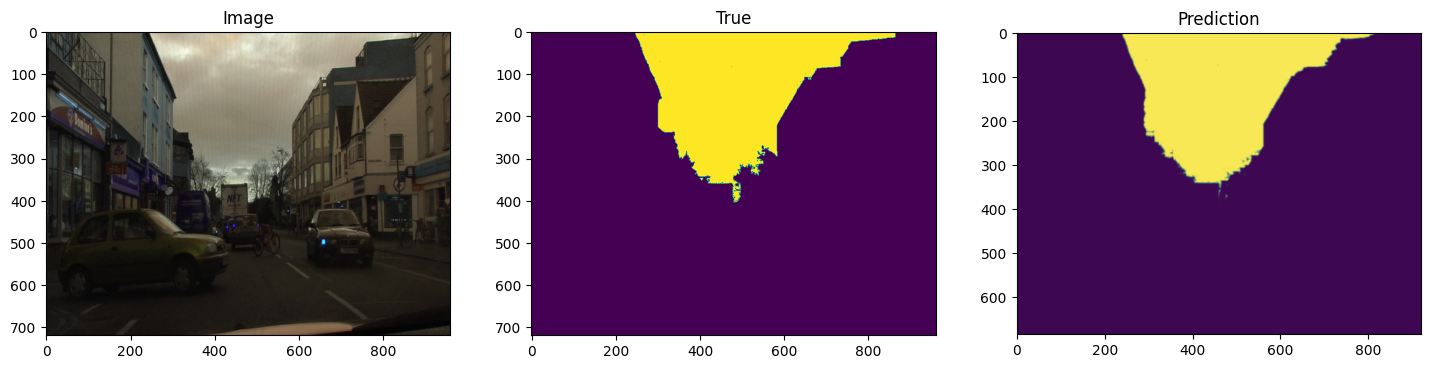

In [121]:
predict(model_llh)

In [122]:
list3 = ['encoder_block45_inv_residual_block2','encoder_block45_inv_residual_block3',
         'encoder_block45_inv_residual_block1',
         'encoder_block45_inv_residual_block2','encoder_block45_inv_residual_block3'
         ]
model_hlh = unet_model(n_classes,(720, 960, 3),study=False,a1=0,a2=1,a3=0)
model_hlh.compile(optimizer='adam', loss='categorical_crossentropy', metrics='accuracy')

# Копирование весов из исходной модели в копию с удаленными слоями
copy_weights1(model,model_hlh,list3)

Отключен режим обучения
Выбрана легкая ветвь
Выбрана тяжелая ветвь
Выбрана легкая ветвь


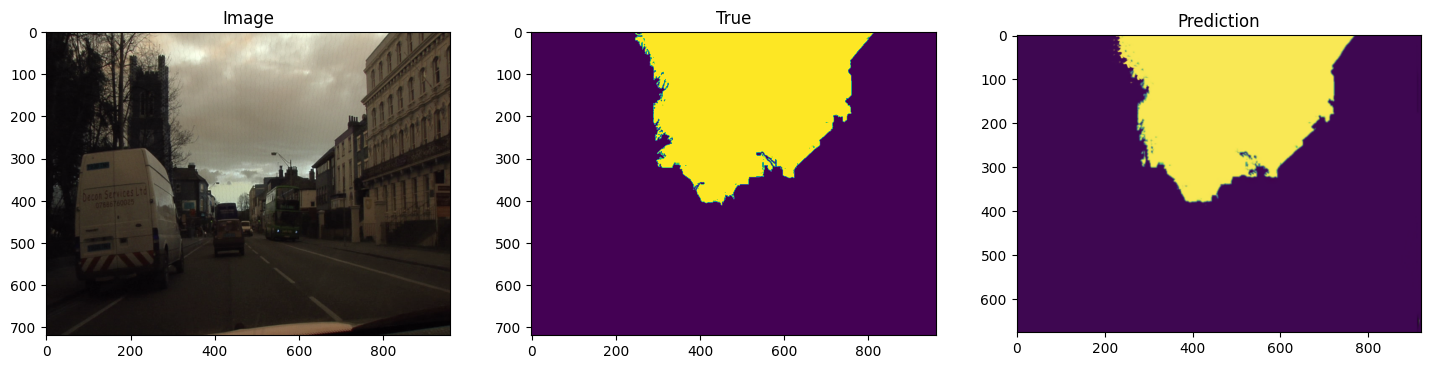

In [124]:
predict(model_hlh)

In [125]:
list4 = ['encoder_block45_inv_residual_block2','encoder_block45_inv_residual_block3',
         'encoder_block45_inv_residual_block2','encoder_block45_inv_residual_block3',
         'encoder_block45_inv_residual_block1'
         ]
model_hhl = unet_model(n_classes,(720, 960, 3),study=False,a1=0,a2=0,a3=1)
model_hhl.compile(optimizer='adam', loss='categorical_crossentropy', metrics='accuracy')

# Копирование весов из исходной модели в копию с удаленными слоями
copy_weights1(model,model_hhl,list4)

Отключен режим обучения
Выбрана легкая ветвь
Выбрана легкая ветвь
Выбрана тяжелая ветвь


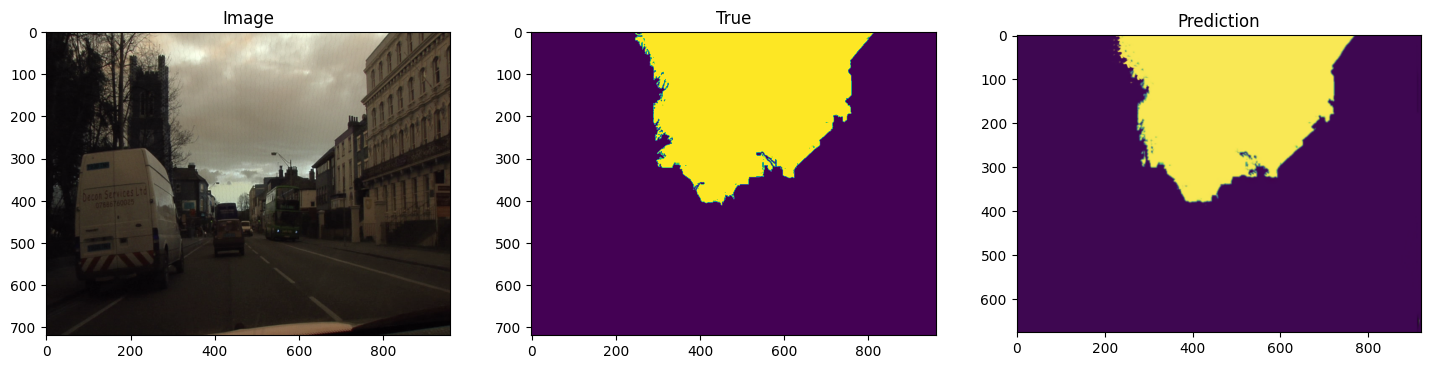

In [126]:
predict(model_hhl)

In [127]:
# Удаление слоев из модели-источника
list5 = ['encoder_block43_inv_residual_block1',
                    'encoder_block45_inv_residual_block1',
                    'encoder_block52_inv_residual_block1',]  # Список частей названий слоев для исключения

model_hhh = unet_model(n_classes,(720, 960, 3),study=False,a1=1,a2=1,a3=1)
model_hhh.compile(optimizer='adam', loss='categorical_crossentropy', metrics='accuracy')

# Копирование весов из исходной модели в копию с удаленными слоями
copy_weights1(model,model_hhh,list5)

Отключен режим обучения
Выбрана тяжелая ветвь
Выбрана тяжелая ветвь
Выбрана тяжелая ветвь


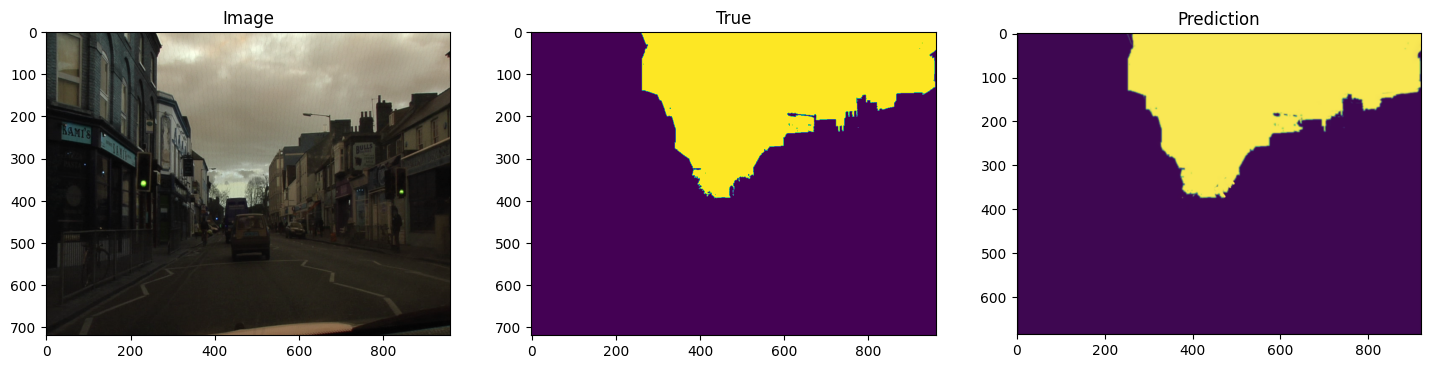

In [143]:
predict(model_hhh)

In [148]:
def calc_iou(y_true, x_test, class_idx, model):
    y_pred = model.predict(x_test)

    true_class = y_true[..., class_idx]
    pred_class = y_pred[..., class_idx]
        
    intersection = np.logical_and(true_class, pred_class)
    union = np.logical_or(true_class, pred_class)
        
    iou = np.sum(intersection) / (np.sum(union) + np.finfo(float).eps)

    return iou

In [155]:
total_params = model_lll.count_params()
print("Количество параметров модели LLL: ", total_params)

# Вычисление IOU для модели на тестовых данных
IOU_score = calc_iou(y_test, X_test, 0, model_lll)
print("Значение model LLL IOU:", mIOU_score)

Количество параметров модели LLL:  3142754
1/1 [==============================] - 6s 6s/step
Значение model LLL IOU: 0.7168543595679013


In [162]:
total_params = model_llh.count_params()
print("Количество параметров модели LLH: ", total_params)

# Вычисление IOU для модели на тестовых данных
IOU_score = calc_iou(y_test, X_test, 0, model_llh)
print("Значение model LLH IOU: ", mIOU_score)

Количество параметров модели LLH:  3234562
1/1 [==============================] - 6s 6s/step
Значение model LLH IOU:  0.7238443500672210


In [161]:
total_params = model_hlh.count_params()
print("Количество параметров модели HLH: ", total_params)

# Вычисление IOU для модели на тестовых данных
IOU_score = calc_iou(y_test, X_test, 0, model_hlh)
print("Значение model HLH IOU:", mIOU_score)

Количество параметров модели HLH:  3344561
1/1 [==============================] - 8s 8s/step
Значение model HLH IOU: 0.7232059500605021


In [163]:
total_params = model_hhl.count_params()
print("Количество параметров модели HHL: ", total_params)

# Вычисление IOU для модели на тестовых данных
IOU_score = calc_iou(y_test, X_test, 0, model_hhl)
print("Значение model HHL IOU:", mIOU_score)

Количество параметров модели HHL:  3490210
1/1 [==============================] - 6s 6s/step
Значение model HHL IOU: 0.7300585486154525


In [164]:
total_params = model_hhh.count_params()
print("Количество параметров модели HHH: ", total_params)

# Вычисление IOU для модели на тестовых данных
IOU_score = calc_iou(y_test, X_test, 0, model_hhh)
print("Значение model HHH IOU:", mIOU_score)

Количество параметров модели HHH:  3673826
1/1 [==============================] - 7s 7s/step
Значение model HHH IOU: 0.7390995486534495


In [168]:
import time
def inference_time(model):
    total_time = 0.0
    for image_number in range(5):
        start_time = time.time()
        model.predict(np.expand_dims(X_test[image_number], 0))[0].argmax(axis=2) + 1
        end_time = time.time()
        step_time = end_time - start_time
        total_time += step_time
    print(average_time = total_time / 5)

1/1 [==============================] - 0s 341ms/step
0.3501671419143676
1/1 [==============================] - 0s 339ms/step
0.3393653488159179
1/1 [==============================] - 0s 327ms/step
0.3290673561096191
1/1 [==============================] - 0s 307ms/step
0.3016060829162597
1/1 [==============================] - 0s 241ms/step
0.2916364142608642
